In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import *
import random as rn
import tensorflow as tf
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import SGD
from keras.layers import LSTM
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('/Users/jolinchen/quant/Data/Stock_1.csv')
print(df.shape)
df = df.loc[:, "PriceFeature_1":]
print( "Number of features: ", df.shape[1] - 1)
print( "Number of entries: ", df.shape[0])
df.head()

(45590, 34)
Number of features:  32
Number of entries:  45590


,PriceFeature_1,PriceFeature_2,PriceFeature_3,PriceFeature_4,PriceFeature_5,PriceFeature_6,PriceFeature_7,PriceFeature_8,VolumeFeature_1,VolumeFeature_2,...,TransactionFeature_1,OrderFeature_1,OrderFeature_2,OrderFeature_3,OrderFeature_4,VolumeFeature_10,VolumeFeature_11,VolumeFeature_12,VolumeFeature_13,TargetFeature
0,5.87,5.88,5.88,5.88,-0.006677,0.008503,False,False,5800.0,False,...,True,10000.0,1.000000,1.000000,0.495798,9100.0,12200.0,14900.0,0.412518,0
1,5.86,5.88,5.88,5.88,-0.006458,0.006803,False,False,4900.0,False,...,True,6200.0,0.549180,0.500000,0.464524,4900.0,5100.0,5600.0,0.173390,0
2,5.87,5.88,5.88,5.88,-0.006434,0.008503,False,False,4500.0,False,...,True,13900.0,0.944444,0.750000,0.859788,8200.0,8200.0,8800.0,0.086252,0
3,5.87,5.88,5.88,5.88,-0.006320,0.008503,False,False,22000.0,False,...,True,12300.0,0.347682,0.571429,0.000000,11300.0,11400.0,19600.0,0.310781,0
4,5.86,5.88,5.88,5.88,-0.006265,0.006803,False,False,3800.0,False,...,True,10500.0,0.480798,0.666667,0.175016,4200.0,15900.0,19300.0,0.152604,0


In [208]:
def clean_data(df):
    # convert bool type data to float
    bool_df = df.select_dtypes(include=['bool']).copy()
    print("Numbers of null value in bool data: ", bool_df.isnull().sum().sum())
    df[list(bool_df.columns)] = df[list(bool_df.columns)].astype(float, copy=False)
    # remove missing and inf data
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    print("datashape after cleaning: ", df.shape)
    return df
df = clean_data(df)

Numbers of null value in bool data:  0
datashape after cleaning:  (25879, 33)


In [210]:
def feature_selection(df):
    X, y = df.drop("TargetFeature",1), df["TargetFeature"]
    clf = ExtraTreesClassifier(n_estimators=100)
    clf = clf.fit(X, y)
    print("feature importance: ", clf.feature_importances_  )
    model = SelectFromModel(clf, prefit=True)
    X_new = model.transform(X)
    cols, names = list(), list()
    for i in df.columns:
        for j in range(X_new.shape[1]):
            if (df[i].values == X_new[:, j]).all():
                cols.append(df[i])
                names.append(i)
    cols.append(y)
    names.append("TargetFeature")
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    print("new data shape: ", agg.shape)
    return agg
df1 = feature_selection(df)
df1.head()

feature importance:  [2.98569247e-02 2.81659670e-02 2.70931660e-02 2.67713604e-02
 3.36472388e-02 3.58513783e-02 9.53853009e-05 6.02957721e-03
 3.18403306e-02 2.67564177e-02 2.79119551e-02 3.58479259e-02
 3.79880329e-02 2.79841199e-02 2.76591385e-02 2.86147506e-02
 3.52993706e-02 2.29672859e-02 2.23243097e-02 2.37379555e-02
 3.27891776e-02 2.71629779e-02 3.20736438e-02 1.38451605e-02
 3.03402901e-02 3.98677796e-02 3.34760225e-02 2.77340531e-02
 5.65197081e-02 6.86486170e-02 7.63907310e-02 2.47092483e-02]
new data shape:  (25879, 14)


,PriceFeature_5,PriceFeature_6,VolumeFeature_1,VolumeFeature_4,VolumeFeature_5,TapeFeature_1,TapeFeature_5,VolumeFeature_9,OrderFeature_2,OrderFeature_3,VolumeFeature_10,VolumeFeature_11,VolumeFeature_12,TargetFeature
203,0.005712,0.003448,1100.0,9576.0,2600.00,0.0,0.0,0.0,0.024096,0.4,0.0,0.0,3400.0,0
204,0.005727,0.005172,400.0,9564.0,2600.00,0.0,0.0,400.0,0.058140,0.4,500.0,500.0,3800.0,0
206,0.005908,0.005172,500.0,9666.0,2478.65,0.0,0.0,0.0,0.857143,0.8,0.0,300.0,600.0,0
207,0.005914,0.006897,12600.0,9864.0,2568.40,0.0,0.0,12600.0,0.981818,0.8,12600.0,12600.0,13200.0,0
208,0.006043,0.006897,13100.0,10051.0,2588.15,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0


In [211]:
# convert time series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True) 
    agg.drop(agg.columns[range(data.shape[1],2*data.shape[1]-1)], axis=1, inplace=True)
    return agg
def scale(df):
    values = df.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    return scaled

## Work on full dataset

Didn't perform feature select as it is not necessary for neural network

In [253]:
reframed = series_to_supervised(scale(df), 1, 1)
print(reframed.head())
print(reframed.shape)
# split into train and test sets
values = reframed.values
n_train_len = math.ceil(values.shape[0]*0.8)
train = values[:n_train_len, :]
test = values[n_train_len:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
def count_unique (variable):
    unique_elements, counts_elements = np.unique(variable, return_counts=True)
    print("Frequency of unique values of the said array:")
    print(np.asarray((unique_elements.astype(int), counts_elements.astype(int))))
count_unique(train_y)
count_unique(test_y)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("Training X shape: ", train_X.shape)
print("Training y shape: ", train_y.shape)
print("Testing X shape: ", test_X.shape)
print("Testing y shape: ", test_y.shape)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.049746   0.048159   0.049236   0.048159   0.521784   0.060953   
2   0.050311   0.048159   0.049236   0.048159   0.521862   0.091430   
3   0.049746   0.048159   0.049236   0.048159   0.522789   0.091430   
4   0.050311   0.048159   0.049236   0.048159   0.522823   0.121907   
5   0.050311   0.048159   0.049236   0.048159   0.523486   0.121907   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var25(t-1)  var26(t-1)  \
1        0.0        0.0   0.000272         0.0  ...    0.000000    0.024096   
2        0.0        0.0   0.000060         0.0  ...    0.000044    0.058140   
3        0.0        0.0   0.000091         0.0  ...    0.000000    0.857143   
4        0.0        0.0   0.003742         0.0  ...    0.002844    0.981818   
5        0.0        0.0   0.003893         0.0  ...    0.000000    0.000000   

   var27(t-1)  var28(t-1)  var29(t-1)  var30(t-1)  var31(t-1)  var32(t-1)  \
1         0.4    0.00

In [254]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(20))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.05)
# m = tf.keras.metrics.PrecisionAtRecall(recall=0.6, num_thresholds=200)
#cannot maximize precision and recall at the same time
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=15, batch_size=5, verbose=0, shuffle=False)
_, accuracy = model.evaluate(test_X, test_y, verbose=0)
print('Accuracy on the test dataset: %.2f' % (accuracy*100))

Accuracy on the test dataset: 97.91


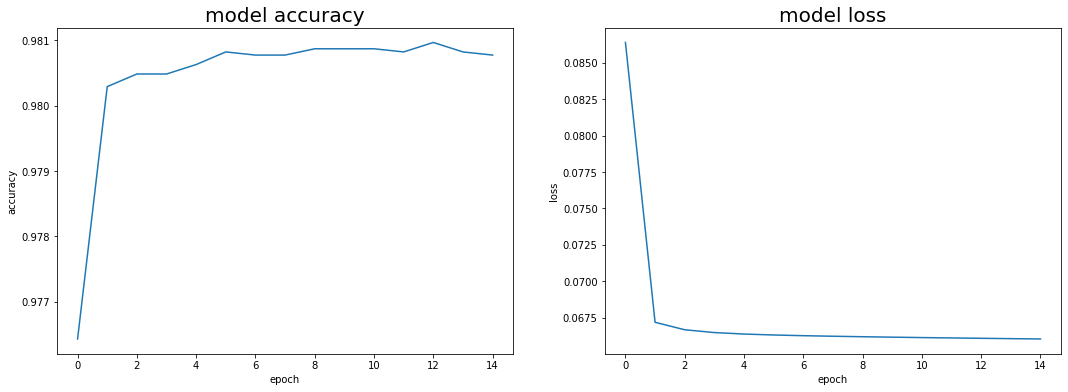

In [255]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,2,1) 
ax.plot(history.history['accuracy'])
plt.title('model accuracy', fontsize = 20)
plt.ylabel('accuracy')
plt.xlabel('epoch')
ax = fig.add_subplot(1,2,2) 
ax.plot(history.history['loss'])
plt.title('model loss', fontsize = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

No Skill: ROC AUC=0.500
NN: ROC AUC=0.874


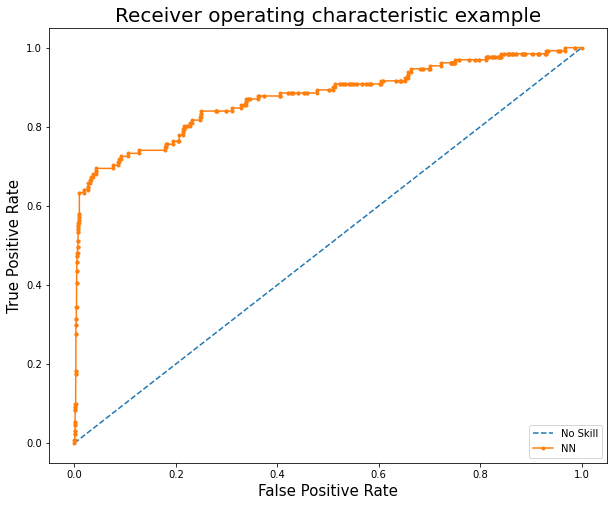

In [256]:
y_score = model.predict(test_X)
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(test_y, y_score)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_y))]
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
no_skill = len(test_y[test_y==1]) / len(test_y)
# roc_auc = auc(fpr, tpr)
# calculate scores
ns_auc = roc_auc_score(test_y, ns_probs)
auc = roc_auc_score(test_y, y_score)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN: ROC AUC=%.3f' % (auc))
plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='NN')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic example', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [257]:
def classify_prediction(y_score):
    for i in range(y_score.shape[0]):
        if y_score[i] >= 0.5:
            y_score[i] = 1
        else:
            y_score[i] = 0
    return y_score
def recall_precision(y_score,test_y):
    precision, recall, fbeta, support = precision_recall_fscore_support(test_y, 
                                                                       classify_prediction(y_score), 
                                                                       pos_label = 1)
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("Fbeta: ", fbeta)
    print("Support: ", support)
    
recall_precision(y_score, test_y)    

Recall:  [0.99702617 0.29007634]
Precision:  [0.98184303 0.71698113]
Fbeta:  [0.98937635 0.41304348]
Support:  [5044  131]


## Work on reduced dataset

Not recommend as shown below, there's a lot of information lost which makes the prediction inaccurate

In [198]:
reframed = series_to_supervised(scale(df1), 1, 1)
print(reframed.head())
print(reframed.shape)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.521784   0.060953   0.000272   0.004571   0.001803        0.0   
2   0.521862   0.091430   0.000060   0.004558   0.001803        0.0   
3   0.522789   0.091430   0.000091   0.004670   0.001461        0.0   
4   0.522823   0.121907   0.003742   0.004887   0.001714        0.0   
5   0.523486   0.121907   0.003893   0.005093   0.001770        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1        0.0   0.000000   0.024096    0.000000    0.000000    0.000906   
2        0.0   0.000121   0.058140    0.000135    0.000134    0.001012   
3        0.0   0.000000   0.857143    0.000000    0.000080    0.000160   
4        0.0   0.003807   0.981818    0.003409    0.003374    0.003517   
5        0.0   0.000000   0.000000    0.000000    0.000000    0.000000   

   var13(t-1)  var13(t)  
1         0.0       0.0  
2         0.0       0.0  
3         0.0       0.0  
4         0.0       0.0 

In [199]:
# split into train and test sets
values = reframed.values
n_train_len = math.ceil(values.shape[0]*0.8)
train = values[:n_train_len, :]
test = values[n_train_len:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
def count_unique (variable):
    unique_elements, counts_elements = np.unique(variable, return_counts=True)
    print("Frequency of unique values of the said array:")
    print(np.asarray((unique_elements.astype(int), counts_elements.astype(int))))
count_unique(train_y)
count_unique(test_y)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Frequency of unique values of the said array:
[[    0     1]
 [20172   531]]
Frequency of unique values of the said array:
[[   0    1]
 [5044  131]]
(20703, 1, 13) (20703,) (5175, 1, 13) (5175,)


In [200]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(20))
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.05)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=15, batch_size=5, verbose=0, shuffle=False)
_, accuracy = model.evaluate(test_X, test_y, verbose=0)
print('Accuracy on the test dataset: %.2f' % (accuracy*100))

Accuracy on the test dataset: 97.93


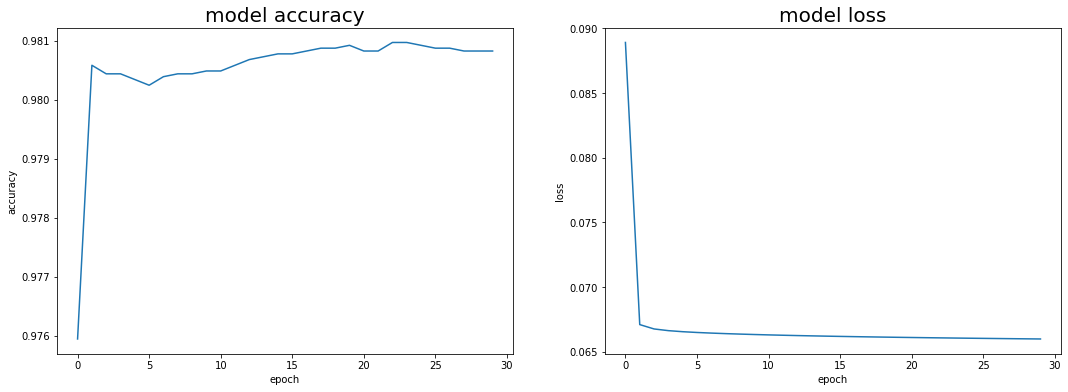

In [201]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,2,1) 
ax.plot(history.history['accuracy'])
plt.title('model accuracy', fontsize = 20)
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train with 100 PCs', 'train with 50 PCs'], loc='upper left')
ax = fig.add_subplot(1,2,2) 
ax.plot(history.history['loss'])
plt.title('model loss', fontsize = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train with 100 PCs', 'train with 50 PCs'], loc='upper right')
plt.show()

No Skill: ROC AUC=0.500
NN: ROC AUC=0.907


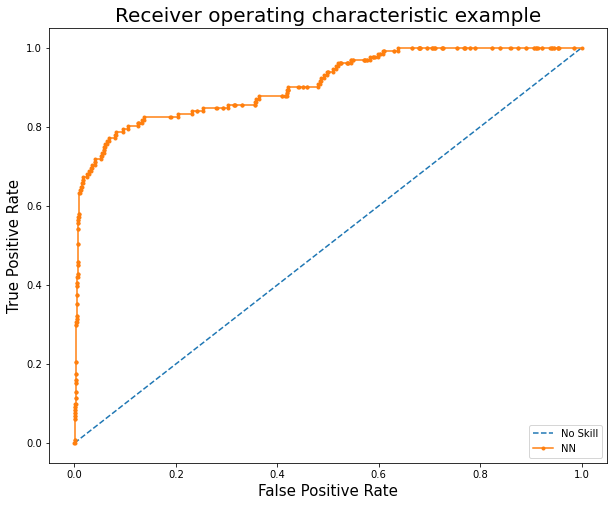

In [202]:
y_score = model.predict(test_X)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(test_y, y_score)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_y))]
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
roc_auc = auc(fpr, tpr)
# calculate scores
ns_auc = roc_auc_score(test_y, ns_probs)
auc = roc_auc_score(test_y, y_score)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('NN: ROC AUC=%.3f' % (auc))
plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='NN')
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic example', fontsize=20)
plt.legend(loc="lower right")
plt.show()

In [206]:
recall_precision(y_score, test_y)    

[0.98506583 0.63953488] [0.99385408 0.41984733] [0.98944044 0.50691244] [5044  131]
